In [329]:
import pickle
from scipy import sparse
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import spektral
import os
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import keras_tuner as kt
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline, BSpline
import pandas as pd
import openpyxl

In [387]:
#counter current
counter = pd.read_excel(r"C:\Users\buing\Documents\CBE 424\heat exchanger\counterflow.xlsx")

In [388]:
print(counter)

       ms     ts  Ms (kg/s)  mi1 (kg)  ti1 (s)  mi2 (kg)  ti2 (s)  Mi1 (kg/s)  \
0    8.53  20.05   0.425436      1.50    40.10      1.52    40.00    0.037406   
1    8.53  20.05   0.425436      5.87    53.02       NaN      NaN    0.110713   
2    8.53  20.05   0.425436      6.94    30.03       NaN      NaN    0.231102   
3    8.53  20.05   0.425436     14.15    40.05       NaN      NaN    0.353308   
4    8.53  20.05   0.425436     12.44    20.24       NaN      NaN    0.614625   
5    8.53  20.05   0.425436      9.78    15.00     12.89    19.99    0.652000   
6   10.78  19.92   0.541165      1.25    60.15      1.26    60.09    0.020781   
7   10.78  19.92   0.541165      4.85    60.10       NaN      NaN    0.080699   
8   10.78  19.92   0.541165      7.60    50.04       NaN      NaN    0.151878   
9   10.78  19.92   0.541165     10.03    40.16       NaN      NaN    0.249751   
10  10.78  19.92   0.541165      7.18    20.18       NaN      NaN    0.355798   
11  10.78  19.92   0.541165 

In [389]:
dat = pd.DataFrame(counter)

In [390]:
hot_rate = dat["Ms (kg/s)"]
cold_rate = dat["Mi1 (kg/s)"]
wc = cold_rate
wh = hot_rate
Th_in = dat["Th_in"]
Th_out = dat["Th_out"]
Tc_in = dat["Tc_in"]
Tc_out = dat["Tc_out"]

In [477]:
error_dat = dat[dat["mi2 (kg)"].notna()]
#print(error_dat)
Ms_err = error_dat["Ms (kg/s)"].to_numpy()
M1 = error_dat["Mi1 (kg/s)"].to_numpy()
M2 = error_dat["mi2 (kg)"].to_numpy()/error_dat["ti2 (s)"].to_numpy()
#print(M1,M2)
Avg_Mi = (M1+M2)/2
std_Mi = np.std([M1, M2],axis = 0)
print(Avg_Mi, std_Mi)

[0.03770324 0.64841121 0.02087496 0.48497808 0.02531743 0.48497808
 0.02531743 0.51787396 0.51787396] [2.96758105e-04 3.58879440e-03 9.35836478e-05 2.85887204e-03
 1.57095002e-04 2.85887204e-03 1.57095002e-04 4.61024905e-04
 4.61024905e-04]


In [524]:
#print(error_dat)
Th_in_err = error_dat["Th_in"]
Th_out_err = error_dat["Th_out"]
Tc_in_err = error_dat["Tc_in"]
Tc_out_err = error_dat["Tc_out"]
Ms_err = error_dat["Ms (kg/s)"]
Gi_err = M1/(np.pi*31*np.power((0.21/39.37),2)/4)
Cp = 4.182
dT_counter_err = ((Th_in_err - Tc_out_err) - (Th_out_err - Tc_in_err))/np.log(((Th_in_err - Tc_out_err)/(Th_out_err - Tc_in_err)))
Qc_err1 = M1*Cp*(Tc_out_err - Tc_in_err)
Qc_err2 = M2*Cp*(Tc_out_err - Tc_in_err)
Qc_avg = (Qc_err1+Qc_err2)/2
Qc_std = np.std([Qc_err1, Qc_err2],axis = 0)
Qh = Ms_err*Cp*(Th_out_err - Th_in_err)
A = 31*np.pi*7.875*0.21/(39.37*39.37)
Q_err1 = (abs(Qc_err1) + abs(Qh))/2
Q_err2 = (abs(Qc_err2) + abs(Qh))/2
U_err1 = Q_err1/(A*dT_counter_err)
U_err2 = Q_err2/(A*dT_counter_err)
U_avg = (U_err1+U_err2)/2
U_std = np.std([U_err1, U_err2],axis = 0)
print(Gi_err)

[ 53.99922805 941.21374474  29.99957114 704.23135268  36.32094105
 704.23135268  36.32094105 748.25768771 748.25768771]


In [526]:
dT_counter = ((Th_in - Tc_out) - (Th_out - Tc_in))/np.log(((Th_in - Tc_out)/(Th_out - Tc_in)))
Cp = 4.182 #kJ/kgC
Qc = wc*Cp*(Tc_out- Tc_in)      #Qc = wc*Cp_c*(Tc_out - Tc_in)
Qh = wh*Cp*(Th_out- Th_in)   #Qh = wh*Cp_h*(Th_out- Th_in)
Q = (abs(Qc) + abs(Qh))/2
A = 31*np.pi*7.875*0.21/(39.37*39.37)
U = Q/(A*dT_counter)
Gi = wc/(np.pi*31*np.power((0.21/39.37),2)/4)
Gs = wh/((np.pi*np.power((2.025/39.37),2)/4)-(np.pi*31*np.power((0.25/39.37),2)/4))
#dT_co = ((Th_in - Tc_in) - (Th_out - Tc_out))/np.log(((Th_in - Tc_in)/(Th_out - Tc_out)))
flip_U = 1/U
print(A,dT_counter[0],U[0],Gs[0])

0.10390838483425208 25.986878426698617 1.3502797738151784 388.14499082989255


In [480]:
print(Gi_err,U_std,U_err1)

[ 53.99922805 941.21374474  29.99957114 704.23135268  36.32094105
 704.23135268  36.32094105 748.25768771 748.25768771] [0.00514524 0.01208733 0.00210971 0.01277722 0.00268354 0.01349056
 0.00274507 0.00196779 0.00199175] 0     1.350280
5     4.398503
6     0.932915
17    4.285565
18    0.861966
23    4.446049
24    0.847314
29    4.421781
35    4.418139
dtype: float64


In [481]:
def func(G,a,b,c,d,e):
    Gi,Gs = G
    return (a/np.power(Gi,b)) + c + (d/np.power(Gs,e))
    #Sieder_tate_LHS = h*D/k
    #Sieder_tate_RHS = 0.023 * (D*G/miu)^0.8 * (Cp*miu/k)^(1/3) * (miu_b/miu_o)^0.14

    #Kern_LHS = h_o*D_e/k
    #Kern_RHS = 0.36 * (D_e*G_s/miu)^0.55 * (Cp*miu/k)^(1/3) * (miu_b/miu_o)^0.14

    #param fitting
    #LHS = 1/U
    #RHS = a/(wc^b) + c + d/(wh^e)

    #hi_exp = 1/a*wc^b
    #h0_exp = (1/d)*(Ai/A0)*(wh^e)


In [482]:
guess = [1, 0.3, 2, 1,0.7]
a,b,c,d,e = guess
LHS = func((Gi,Gs),a,b,c,d,e)
param = curve_fit(func,(Gi,Gs),flip_U,guess,bounds=(0, [30, 3, 10,30,10]))
LHS_fit = func((Gi,Gs),*param[0])
U_fit = 1/LHS_fit

print(param)

(array([30.        ,  0.98426514,  0.20580751,  0.44152376,  5.93986915]), array([[5.11824240e+01, 5.42480063e-01, 1.46191544e-01, 0.00000000e+00,
        0.00000000e+00],
       [5.42480063e-01, 5.85595432e-03, 1.66619262e-03, 0.00000000e+00,
        0.00000000e+00],
       [1.46191544e-01, 1.66619262e-03, 6.76561972e-04, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]]))


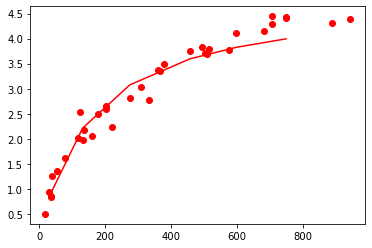

In [483]:
plt.plot(Gi,U,'ro')
Gi1 = Gi[0:6]
Gi2 = Gi[6:12]
Gi3 = Gi[12:18]
Gi4 = Gi[18:24]
Gi5 = Gi[24:30]
Gi6 = Gi[30:36]
Gs1 = Gs[0:6]
Gs2 = Gs[6:12]
Gs3 = Gs[12:18]
Gs4 = Gs[18:24]
Gs5 = Gs[24:30]
Gs6 = Gs[30:36]
U1 = U[0:6]
U2 = U[6:12]
U3 = U[12:18]
U4 = U[18:24]
U5 = U[24:30]
U6 = U[30:36]
Gs_1_fit = 1/(func((Gi[0:6],Gs[0:6]),*param[0]))
Gs_2_fit = 1/(func((Gi[6:12],Gs[6:12]),*param[0]))
Gs_3_fit = 1/(func((Gi[12:18],Gs[12:18]),*param[0]))
Gs_4_fit = 1/(func((Gi[18:24],Gs[18:24]),*param[0]))
Gs_5_fit = 1/(func((Gi[24:30],Gs[24:30]),*param[0]))
Gs_6_fit = 1/(func((Gi[30:36],Gs[30:36]),*param[0]))
#plt.plot(Gi[0:6],Gs_1_fit,'r-')
#plt.plot(Gi[6:12],Gs_2_fit,'r-')
#plt.plot(Gi[12:18],Gs_3_fit,'r-')
#plt.plot(Gi[18:24],Gs_4_fit,'r-')
plt.plot(Gi[24:30],Gs_5_fit,'r-')

<ErrorbarContainer object of 3 artists>

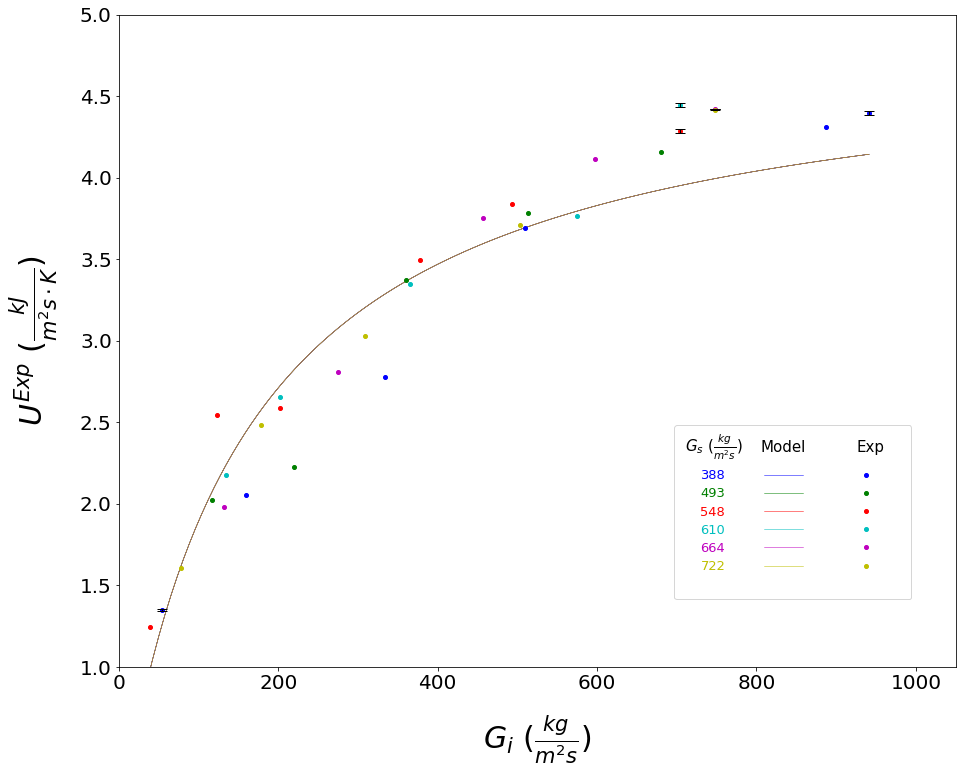

In [516]:
Gi_spline_1 = np.sort(Gi1)
Gi_spline_2 = np.sort(Gi2)
Gi_spline_3 = np.sort(Gi3)
Gi_spline_4 = np.sort(Gi4)
Gi_spline_5 = np.sort(Gi5)
Gi_spline_6 = np.sort(Gi6)

#U_spline_1 = 1/func((Gi_spline_1,Gs1),*param[0])
#U_spline_2 = 1/func((Gi_spline_1,Gs2),*param[0])
#U_spline_3 = 1/func((Gi_spline_1,Gs3),*param[0])
#U_spline_4 = 1/func((Gi_spline_1,Gs4),*param[0])
#U_spline_5 = 1/func((Gi_spline_1,Gs5),*param[0])
#U_spline_6 = 1/func((Gi_spline_1,Gs6),*param[0])
#D_model = np.linspace(D_spline.min(), D_spline.max(), 500)
Gi_model = np.linspace(Gi.min(),Gi.max(),120)
Gi_model1 = np.linspace(Gi1.min(), Gi1.max(), 120)
Gi_model2 = np.linspace(Gi2.min(), Gi2.max(), 120)
Gi_model3 = np.linspace(Gi3.min(), Gi3.max(), 120)
Gi_model4 = np.linspace(Gi4.min(), Gi4.max(), 120)
Gi_model5 = np.linspace(Gi5.min(), Gi5.max(), 120)
Gi_model6 = np.linspace(Gi6.min(), Gi6.max(), 120)
#Gi1_spl = make_interp_spline(Gi_spline_1,U_spline_1)
#Gi2_spl = make_interp_spline(Gi_spline_2,U_spline_2)
#Gi3_spl = make_interp_spline(Gi_spline_3,U_spline_3)
#Gi4_spl = make_interp_spline(Gi_spline_4,U_spline_4)
#Gi5_spl = make_interp_spline(Gi_spline_5,U_spline_5)
#Gi6_spl = make_interp_spline(Gi_spline_6,U_spline_6)
Gs_model1 = np.repeat(Gs1,20)
Gs_model2 = np.repeat(Gs2,20)
Gs_model3 = np.repeat(Gs3,20)
Gs_model4 = np.repeat(Gs4,20)
Gs_model5 = np.repeat(Gs5,20)
Gs_model6 = np.repeat(Gs6,20)
U1_model =  1/func((Gi_model,Gs_model1),*param[0])
U2_model = 1/func((Gi_model,Gs_model2),*param[0])
U3_model = 1/func((Gi_model,Gs_model3),*param[0])
U4_model = 1/func((Gi_model,Gs_model4),*param[0])
U5_model = 1/func((Gi_model,Gs_model5),*param[0])
U6_model = 1/func((Gi_model,Gs_model6),*param[0])
label = np.unique(Gs)
l_width = 0.5
marksize = 4
figure(figsize = (15,12))
plt.plot(Gi_model,U1_model,'b-',linewidth = l_width,label =str(int(label[0])))
#plt.annotate(int(label[0]),
#             xy = (   Gi_model[-1],(U1_model.to_numpy())[-1]),
#             xytext= (  0.95*Gi_model[-1],0.95*(U1_model.to_numpy())[-1]),
#             color = 'b'
#            )

plt.plot(Gi_model,U2_model,'g-',linewidth = l_width,label =str(int(label[1])))
#plt.annotate(int(label[1]),
#             xy = (   Gi_model[-1],(U2_model.to_numpy())[-1]),
#             xytext= (   0.95*Gi_model[-1],0.95*(U2_model.to_numpy())[-1]),
#             color = 'g'
#            )

plt.plot(Gi_model,U3_model,'r-',linewidth = l_width,label =str(int(label[2])))
#plt.annotate(int(label[2]),
#             xy = (   Gi_model[-1],(U3_model.to_numpy())[-1]),
#             xytext= (   Gi_model[-1],0.98*(U3_model.to_numpy())[-1]),
#             color = 'r'
#            )
plt.plot(Gi_model,U4_model,'c-',linewidth = l_width,label =str(int(label[3])))
#plt.annotate(int(label[3]),
#             xy = (   Gi_model[-1],(U4_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],0.99*(U4_model.to_numpy())[-1]),
#             color = 'c'
#            )
plt.plot(Gi_model,U5_model,'m-',linewidth = l_width,label =str(int(label[4])))
#plt.annotate(int(label[4]),
#             xy = (   Gi_model[-1],(U5_model.to_numpy())[-1]),
 #            xytext= (   1.02*Gi_model[-1],1.01*(U5_model.to_numpy())[-1]),
 #            color = 'm'
#            )
plt.plot(Gi_model,U6_model,'y-',linewidth = l_width,label =str(int(label[5])))
#plt.annotate(int(label[5]),
#             xy = (   Gi_model[-1],(U6_model.to_numpy())[-1]),
#             xytext= (   0.97*Gi_model[-1],1.01*(U6_model.to_numpy())[-1]),
#             color = 'y'
#            )
plt.plot(Gi1,U1,'bo',markersize = marksize, label = " ") #str(int(label[0])))
plt.plot(Gi2,U2,'go',markersize = marksize, label = " ") #str(int(label[1])))
plt.plot(Gi3,U3,'ro',markersize = marksize, label = " ") # str(int(label[2])))
plt.plot(Gi4,U4,'co',markersize = marksize, label = " ") # str(int(label[3])))
plt.plot(Gi5,U5,'mo',markersize = marksize, label = " ") # str(int(label[4])))
plt.plot(Gi6,U6,'yo',markersize = marksize, label = " ") # str(int(label[5])))

#plt.annotate("$G_s^{model}$ $(kg/$$m^{2}$s)",
 #            xy = (   Gi_model[-1],(U5_model.to_numpy())[-1]),
 #            xytext= (0.9*Gi_model[-1],1.07*(U5_model.to_numpy())[-1]),
 #            fontsize = 14
 #           )
#legend = plt.legend(loc = 'lower right', fontsize = 13, title = "$G_s^{Exp}$ $(kg/$$m^{2}$s)")
legend = plt.legend(ncol = 2, loc = 'lower right', fontsize = 13, title = " ",markerfirst = False,labelcolor =('b','g','r','c','m','y'),labelspacing = 0.4
                   ,handlelength =3,handletextpad = 3,columnspacing = 0,bbox_to_anchor = (0.95,0.1),frameon = True,borderpad = 2,borderaxespad = 0.2) #^{Exp}
legend.get_title().set_fontsize('13')

plt.text(710,2.32,r"$G_s$ $(\frac{kg} {m^{2}s})$",
             #xy = (   Gi_model[-1],(U5_model.to_numpy())[-1]),
             #xytext= (0.59*Gi_model[-1],0.55*(U5_model.to_numpy())[-1]),
            fontsize = 15, zorder = 100
            )

plt.text(805,2.32, 'Model', fontsize = 15, zorder =100)
plt.text(925,2.32, 'Exp', fontsize = 15, zorder =100)

plt.ylim(1,5)
plt.xlim(0,1050)
plt.ylabel(r"$U^{Exp}$ $(\frac{kJ} {m^{2}s \cdot{K}})$", fontsize = 30,labelpad=20)
plt.xlabel(r"$G_i$ $(\frac{kg} {m^{2}s})$",fontsize = 30,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.errorbar(Gi_err,U_err1,yerr = [U_std], fmt = 'none',ecolor = 'black',capsize = 5,elinewidth = 1)
#spl = make_interp_spline(D_spline,phin_model_point)
#color = cm.rainbow(np.linspace(0, 1, n))
#for i, c in zip(range(n), color):
#   plt.plot(x, y, c=c)


In [261]:
print(Gi_model[-1])
print( str(int(label[0])) + " exp")

941.2137447425847
433 exp


In [149]:
print(Gi_spline_1,Gi[0:6])

[ 53.99922805 159.82291327 333.61441159 510.02866387 887.25925282
 941.21374474] 0     53.999228
1    159.822913
2    333.614412
3    510.028664
4    887.259253
5    941.213745
Name: Mi1 (kg/s), dtype: float64


In [150]:
print(Gi_spline_1)

[ 53.99922805 159.82291327 333.61441159 510.02866387 887.25925282
 941.21374474]


In [332]:
flip_U

0     0.350901
1     0.226743
2     0.173598
3     0.140810
4     0.123190
5     0.120999
6     0.467820
7     0.224546
8     0.193291
9     0.141857
10    0.127866
11    0.118162
12    0.367594
13    0.192679
14    0.173016
15    0.133571
16    0.122935
17    0.111941
18    0.434674
19    0.198015
20    0.165786
21    0.133531
22    0.120505
23    0.105428
24    0.430934
25    0.204658
26    0.149732
27    0.118432
28    0.109955
29    0.103549
30    0.661619
31    0.249811
32    0.167908
33    0.138282
34    0.116164
35    0.100746
dtype: float64